In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

from etl.util import prepare_dataset_without_leakage
from ml_features.features import prepare_features
from ml_features.customer_features import create_customer_features
from ml_features.sequence_features  import create_sequence_features
from ml_features.brand_features import create_brand_features
from ml_features.model_features import create_model_features
from ml_features.market_features import create_market_features
from ml_features.equipment_features import create_equipment_features
from ml_features.solution_complexity_features import create_solution_complexity_features
from ml_features.timeline_features import create_timeline_features, create_advanced_timeline_features, create_timeline_interaction_features
from ml_features.role_features import create_commercial_role_features
from ml_features.process_features import create_process_features
from ml_training.train_rf import train_rf
from ml_evaluation.dashboard import model_evaluation_report

import warnings
warnings.filterwarnings('ignore')

# Load original clean quote data
df_quotes = pd.read_csv('cleaned_quote_data.csv')
df_quotes['dt_creation_devis'] = pd.to_datetime(df_quotes['dt_creation_devis'])


In [2]:
print(f"\n📊 Original quote data: {len(df_quotes):,} quotes from {df_quotes['numero_compte'].nunique():,} customers")


print("\n" + "="*80)
print("STRATEGY: CREATE MEANINGFUL SEQUENCE FEATURES")
print("="*80)

# 1. Enhanced customer features
customer_df = create_customer_features(df_quotes)
print(len(customer_df))

# 2. Sequence features (for multi-quote customers)
sequence_df = create_sequence_features(df_quotes)
print(len(sequence_df))


📊 Original quote data: 34,014 quotes from 23,888 customers

STRATEGY: CREATE MEANINGFUL SEQUENCE FEATURES
Creating enhanced customer features...
  Total customers: 23,888
✓ Created features for 23,888 customers
✓ New features: ['numero_compte', 'total_quotes', 'converted', 'avg_days_between_quotes', 'std_days_between_quotes', 'max_days_between_quotes', 'engagement_density', 'price_trajectory', 'unique_product_families', 'product_consistency']...
23888
Creating sequence features (this may take a moment)...
  Total customers: 23,888
✓ Created features for 23,888 customers
✓ New features: ['numero_compte', 'total_quotes', 'converted', 'avg_days_since_first_quote', 'std_days_since_first_quote', 'max_days_since_first_quote', 'avg_recent_quote_count', 'std_recent_quote_count', 'avg_recent_avg_price', 'std_recent_avg_price']...
23888


In [3]:
new_df_ = create_brand_features(df_quotes)
brand_df = new_df_
new_df = create_model_features(df_quotes)

new_df = pd.merge(
    new_df, 
    new_df_, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')
print(len(new_df))

CREATING BRAND INTELLIGENCE FEATURES
Processing brand data for 23,888 customers
Total quotes with brand info: 33,380
Unique brands in dataset: 93

✅ Created 12 brand intelligence features
   Samples: 23,888

📊 BRAND FEATURES SUMMARY:
--------------------------------------------------
brand_data_available           : mean=0.983, std=0.131
brand_loyalty_index            : mean=0.908, std=0.215
brand_switches                 : mean=0.179, std=0.454
prefers_premium_brand          : mean=0.253, std=0.435
prefers_budget_brand           : mean=0.294, std=0.456
prefers_top_10_brand           : mean=0.783, std=0.412
top_brand_share                : mean=0.908, std=0.215
brand_exploration_score        : mean=0.133, std=0.324
market_share_weighted_brand_score : mean=0.089, std=0.063
brand_consistency              : mean=0.828, std=0.377
... and 2 more features
CREATING MODEL COMPLEXITY & SPECIALIZATION FEATURES
Processing model data for 23,888 customers
Total quotes with model info: 33,991
Unique

In [4]:
new_df_ = create_market_features(df_quotes)
new_df = pd.merge(
    new_df, 
    new_df_, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')
print(len(new_df))

CREATING MARKET POSITION FEATURES
Processing market position data for 23,888 customers
Total quotes with brand info: 33,380

✅ Created 20 market position features
   Samples: 23,888

📊 MARKET POSITION FEATURES SUMMARY:
------------------------------------------------------------
market_data_available               : mean=0.983, std=0.131, non-zero=98.3%
brand_popularity_alignment          : mean=0.091, std=0.065, non-zero=98.3%
brand_popularity_variance           : mean=0.000, std=0.001, non-zero=17.2%
top_10_brand_ratio                  : mean=0.782, std=0.395, non-zero=81.5%
top_5_brand_ratio                   : mean=0.594, std=0.467, non-zero=64.9%
premium_brand_ratio                 : mean=0.256, std=0.418, non-zero=30.4%
budget_brand_ratio                  : mean=0.311, std=0.441, non-zero=36.4%
prefers_niche_brands                : mean=0.214, std=0.392, non-zero=24.7%
brand_conversion_alignment          : mean=0.306, std=0.062, non-zero=100.0%
brand_conversion_consistency       

In [5]:
new_df_ = create_equipment_features(df_quotes)
equipment_df = new_df_
new_df = pd.merge(
    new_df, 
    new_df_, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')
print(len(new_df))

CREATING EQUIPMENT UPGRADE PATH FEATURES
Processing equipment upgrade data for 23,888 customers
Total quotes with equipment info: 34,014

✅ Created 25 equipment upgrade features
   Samples: 23,888

📊 KEY UPGRADE FEATURES SUMMARY:
------------------------------------------------------------
equipment_family_consistency        : mean=0.929, std=0.256, non-zero=92.9%
upgrade_trajectory_score            : mean=-0.003, std=0.240, non-zero=6.6%
has_upgrade                         : mean=0.028, std=0.164, non-zero=2.8%
seasonal_equipment_mix              : mean=0.048, std=0.209, non-zero=5.1%
equipment_maturity_level            : mean=0.423, std=0.053, non-zero=100.0%
equipment_variety_index             : mean=0.055, std=0.213, non-zero=7.1%
has_multi_season                    : mean=0.051, std=0.219, non-zero=5.1%
early_technology_adopter            : mean=0.198, std=0.398, non-zero=19.8%
23888


In [6]:
new_df_ = create_solution_complexity_features(df_quotes)
new_df = pd.merge(
    new_df, 
    new_df_, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')
print(len(new_df))

CREATING SOLUTION COMPLEXITY FEATURES
Processing solution complexity for 23,888 customers

✅ Created 20 solution complexity features
   Samples: 23,888

📊 SOLUTION COMPLEXITY FEATURES SUMMARY:
------------------------------------------------------------
multi_system_count                  : mean=0.936, std=0.313
solution_complexity_score           : mean=2.717, std=0.940
has_complete_heating_solution       : mean=0.000, std=0.000
energy_efficiency_score             : mean=0.663, std=1.369
system_integration_level            : mean=0.017, std=0.123
primary_system_dominance            : mean=0.968, std=0.119
sophistication_score                : mean=0.972, std=0.756
future_proofing_score               : mean=0.054, std=0.108
23888


In [7]:
new_df_ = create_timeline_features(df_quotes)
new_df = pd.merge(
    new_df, 
    new_df_, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')
print(len(new_df))

CREATING SAFE TIMELINE FEATURES (NO LEAKAGE)
Using safe date column: 'dt_creation_devis'
Processing 23,888 customers

✅ Created 7 SAFE timeline features
   REMOVED: company_tenure_days, first_quote_recency (potential leakage)
23888


In [8]:
new_df_ = create_advanced_timeline_features(df_quotes)
new_df = pd.merge(
    new_df, 
    new_df_, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')
print(len(new_df))

Creating ADVANCED timeline features...
23888


In [9]:
new_df_ = create_timeline_interaction_features(new_df_, brand_df, equipment_df)
new_df = pd.merge(
    new_df, 
    new_df_, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')
print(len(new_df))

23888


In [10]:
new_df_ = create_commercial_role_features(df_quotes)
new_df = pd.merge(
    new_df, 
    new_df_, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')
print(len(new_df))

✅ Created 3 LEAKAGE-SAFE commercial features
   REMOVED: total_quotes, unique_roles, senior_commercial_count (potential leakage)
23888


In [11]:
new_df_ = create_process_features(df_quotes)
new_df = pd.merge(
    new_df, 
    new_df_, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')
print(len(new_df))

Created 11 process features
→ 34,014 quotes | 23,888 customers
34014


Columns: ['numero_compte', 'avg_days_since_first_quote', 'std_days_since_first_quote', 'max_days_since_first_quote', 'avg_recent_quote_count', 'std_recent_quote_count', 'avg_recent_avg_price', 'std_recent_avg_price', 'avg_recent_price_std', 'std_recent_price_std', 'avg_recent_product_variety', 'std_recent_product_variety', 'avg_recent_conversion_rate', 'std_recent_conversion_rate', 'avg_current_price', 'std_current_price', 'sequence_quote_ratio', 'price_trend', 'conversion_rate_trend', 'total_quotes', 'converted', 'avg_days_between_quotes', 'std_days_between_quotes', 'max_days_between_quotes', 'engagement_density', 'price_trajectory', 'unique_product_families', 'product_consistency', 'avg_price', 'price_range', 'price_volatility', 'main_agency', 'main_region', 'avg_discount_pct']

🔧 ENCODING & PREPARING FOR MODELING...
  Preparing Customer Features...
  Features: 14, Samples: 23888

🔧 ENCODING & PREPARING FOR MODELING...
  Preparing Sequence Features...
  Features: 32, Samples: 23888



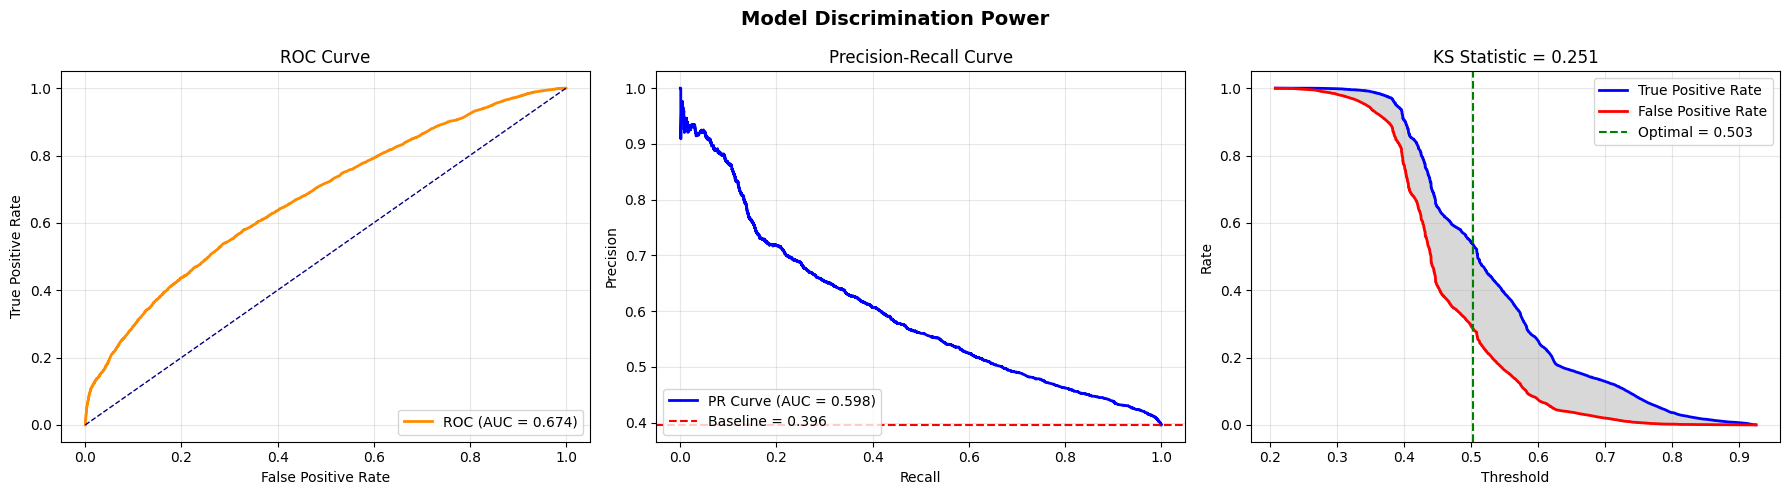

• ROC-AUC: 0.6744
• PR-AUC: 0.5980
• KS Statistic: 0.251 (WEAK discrimination)
• Optimal Threshold: 0.503

💼 STEP 2: BUSINESS IMPACT
----------------------------------------
Verification of decile assignment:
Decile 1 mean prob: 0.731
Decile 10 mean prob: 0.349


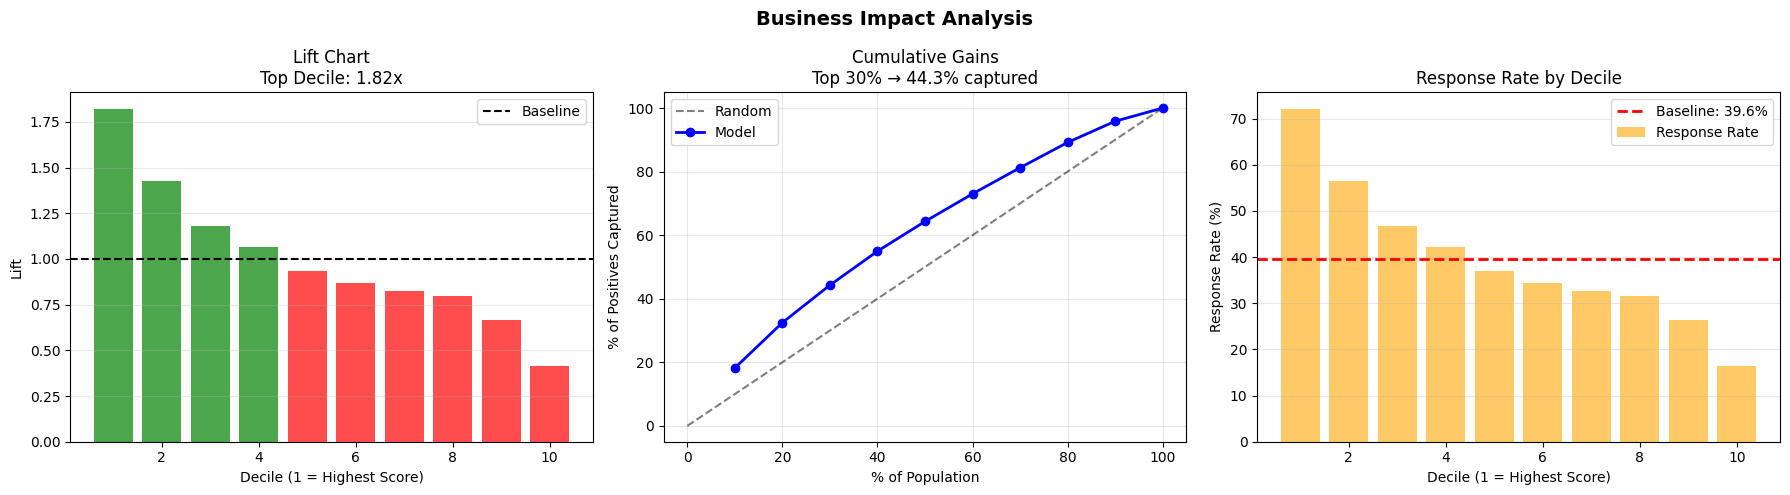

• Top Decile Lift: 0.42x
• Top 30% captures: 44.3% of positives
• Baseline response rate: 39.6%
• Top decile response: 72.1%

📈 STEP 4: CONFUSION MATRIX
----------------------------------------


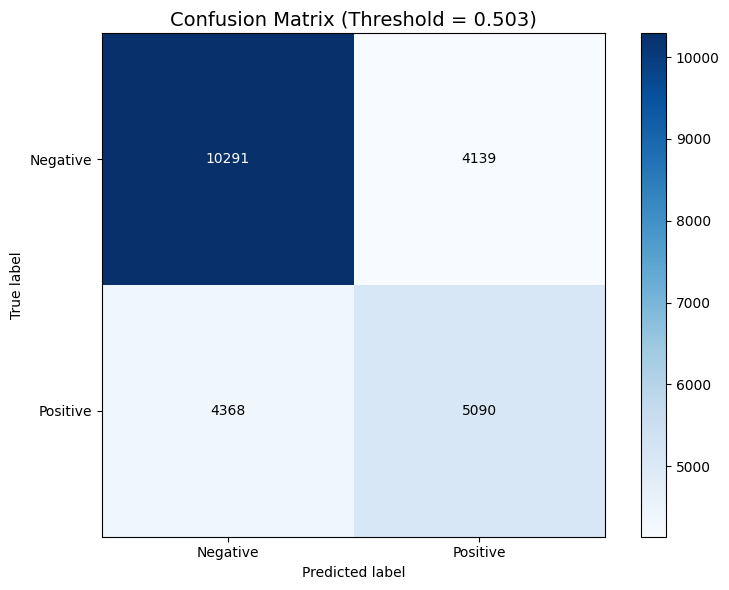

At threshold 0.503:
• Accuracy: 0.644
• Precision: 0.552
• Recall: 0.538
• F1-Score: 0.545
• True Positives: 5090
• False Positives: 4139
• True Negatives: 10291
• False Negatives: 4368

FINAL VALIDATION SUMMARY

✅ DISCRIMINATION POWER:
   KS Statistic: 0.251 (WEAK discrimination)

✅ BUSINESS VALUE:
   Efficiency: 0.42x better than random
   Coverage: Top 30% → 44.3% captured

✅ MODEL QUALITY:
   ROC-AUC: 0.6744 (Excellent if >0.8)
   PR-AUC: 0.5980 (Excellent if >0.7)

✅ OPERATIONAL METRICS:
   Optimal Threshold: 0.503
   Precision at threshold: 0.552
   Recall at threshold: 0.538

🧪 TEST 2: SEQUENCE FEATURES (Advanced)
✓ Model saved: sequence_prediction_model.pkl
✓ AUC: 0.677
COMPLETE MODEL VALIDATION PACKAGE

📊 STEP 1: DISCRIMINATION POWER
----------------------------------------


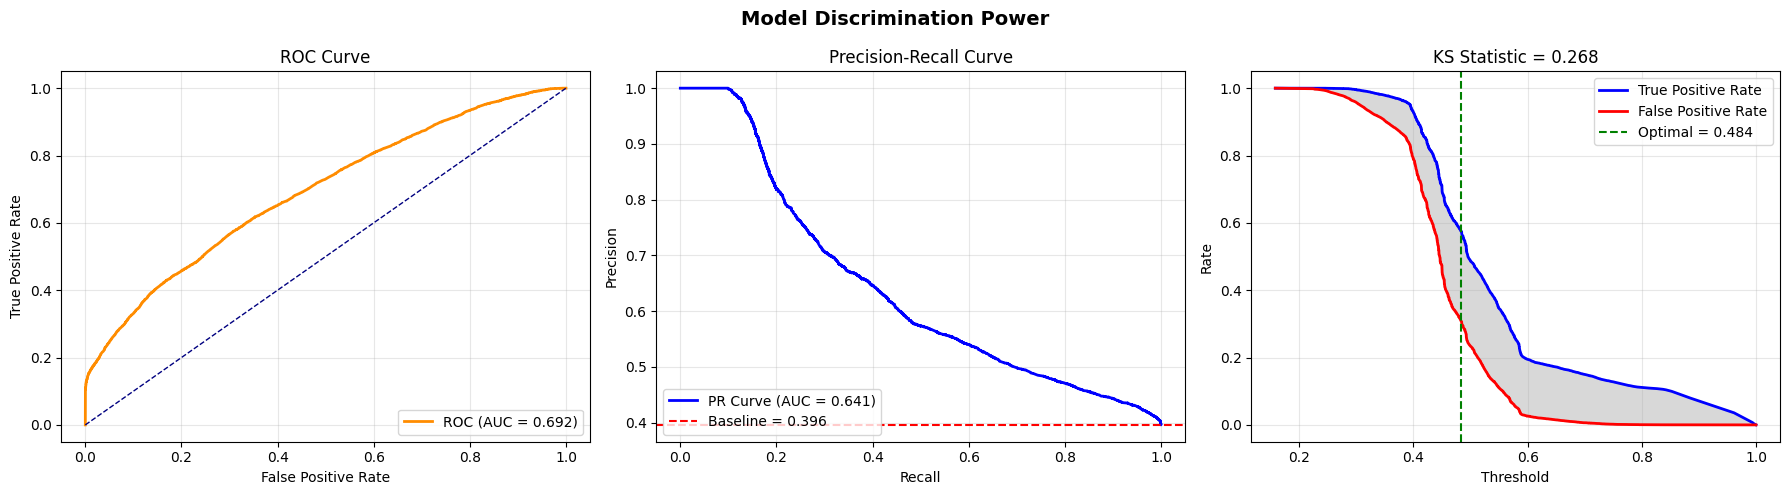

• ROC-AUC: 0.6919
• PR-AUC: 0.6412
• KS Statistic: 0.268 (WEAK discrimination)
• Optimal Threshold: 0.484

💼 STEP 2: BUSINESS IMPACT
----------------------------------------
Verification of decile assignment:
Decile 1 mean prob: 0.782
Decile 10 mean prob: 0.324


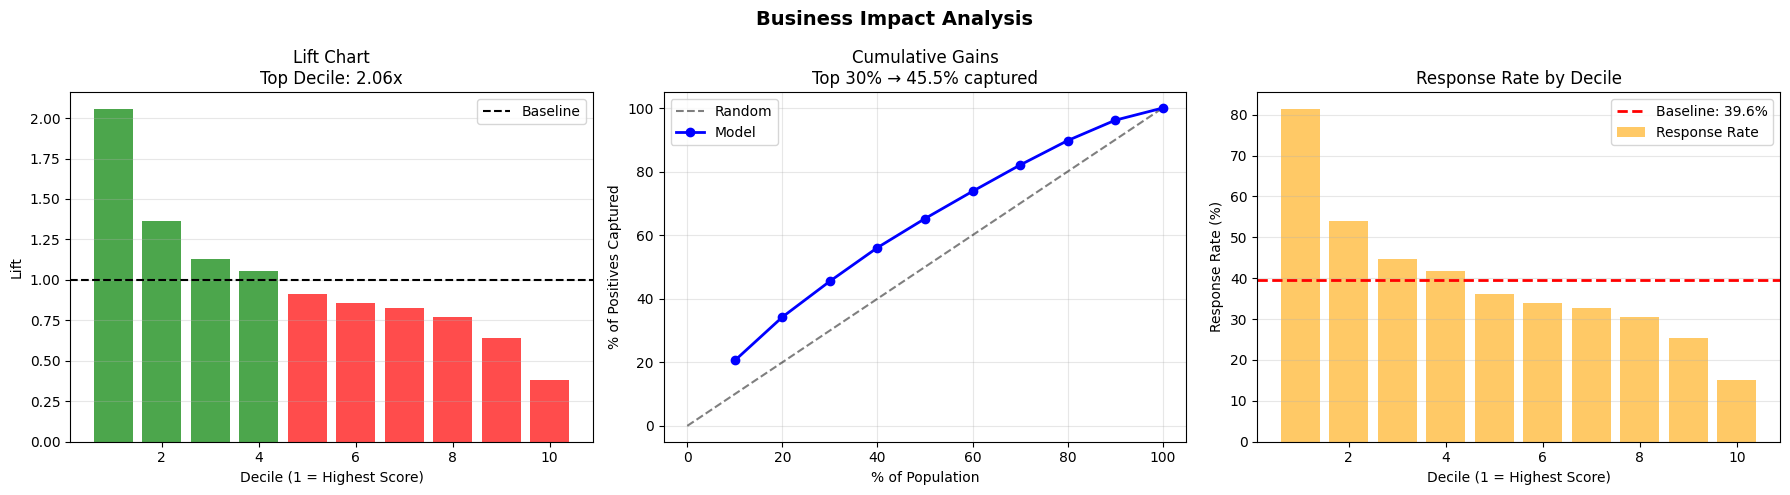

• Top Decile Lift: 0.38x
• Top 30% captures: 45.5% of positives
• Baseline response rate: 39.6%
• Top decile response: 81.5%

📈 STEP 4: CONFUSION MATRIX
----------------------------------------


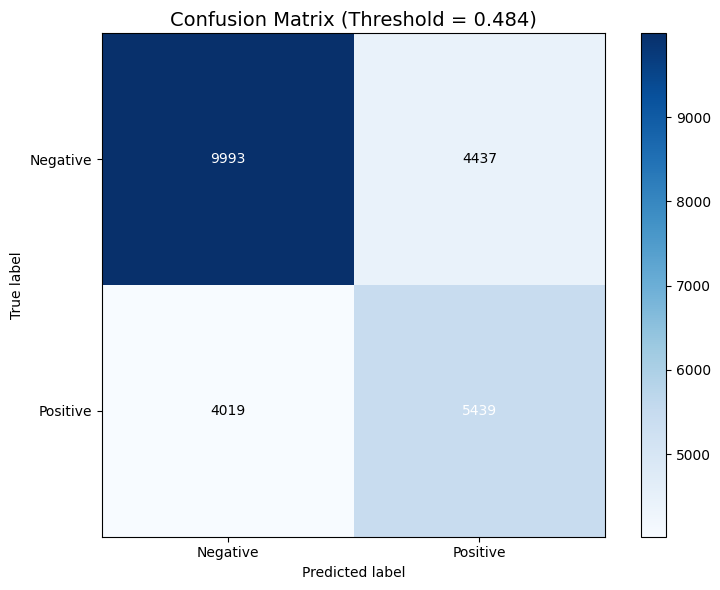

At threshold 0.484:
• Accuracy: 0.646
• Precision: 0.551
• Recall: 0.575
• F1-Score: 0.563
• True Positives: 5439
• False Positives: 4437
• True Negatives: 9993
• False Negatives: 4019

FINAL VALIDATION SUMMARY

✅ DISCRIMINATION POWER:
   KS Statistic: 0.268 (WEAK discrimination)

✅ BUSINESS VALUE:
   Efficiency: 0.38x better than random
   Coverage: Top 30% → 45.5% captured

✅ MODEL QUALITY:
   ROC-AUC: 0.6919 (Excellent if >0.8)
   PR-AUC: 0.6412 (Excellent if >0.7)

✅ OPERATIONAL METRICS:
   Optimal Threshold: 0.484
   Precision at threshold: 0.551
   Recall at threshold: 0.575

🧪 TEST 3: NEW FEATURES (Advanced)
✓ Model saved: sequence_prediction_model.pkl
✓ AUC: 0.760
COMPLETE MODEL VALIDATION PACKAGE

📊 STEP 1: DISCRIMINATION POWER
----------------------------------------


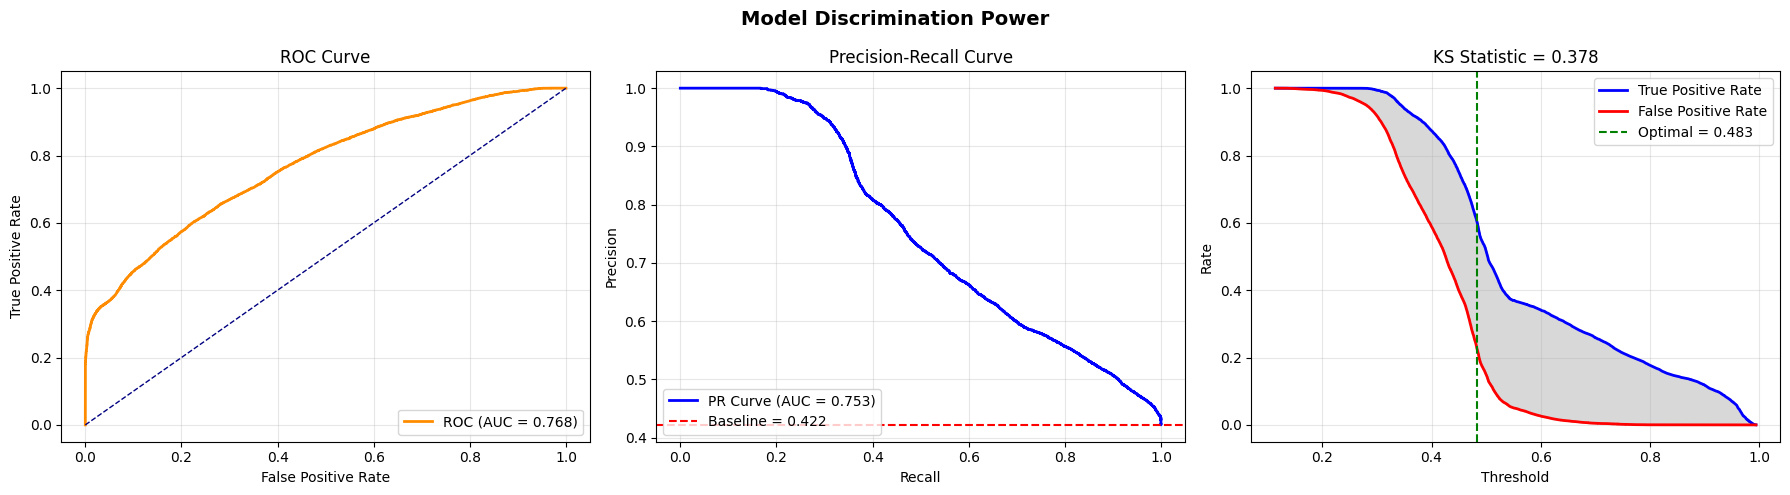

• ROC-AUC: 0.7680
• PR-AUC: 0.7533
• KS Statistic: 0.378 (MODERATE discrimination)
• Optimal Threshold: 0.483

💼 STEP 2: BUSINESS IMPACT
----------------------------------------
Verification of decile assignment:
Decile 1 mean prob: 0.878
Decile 10 mean prob: 0.288


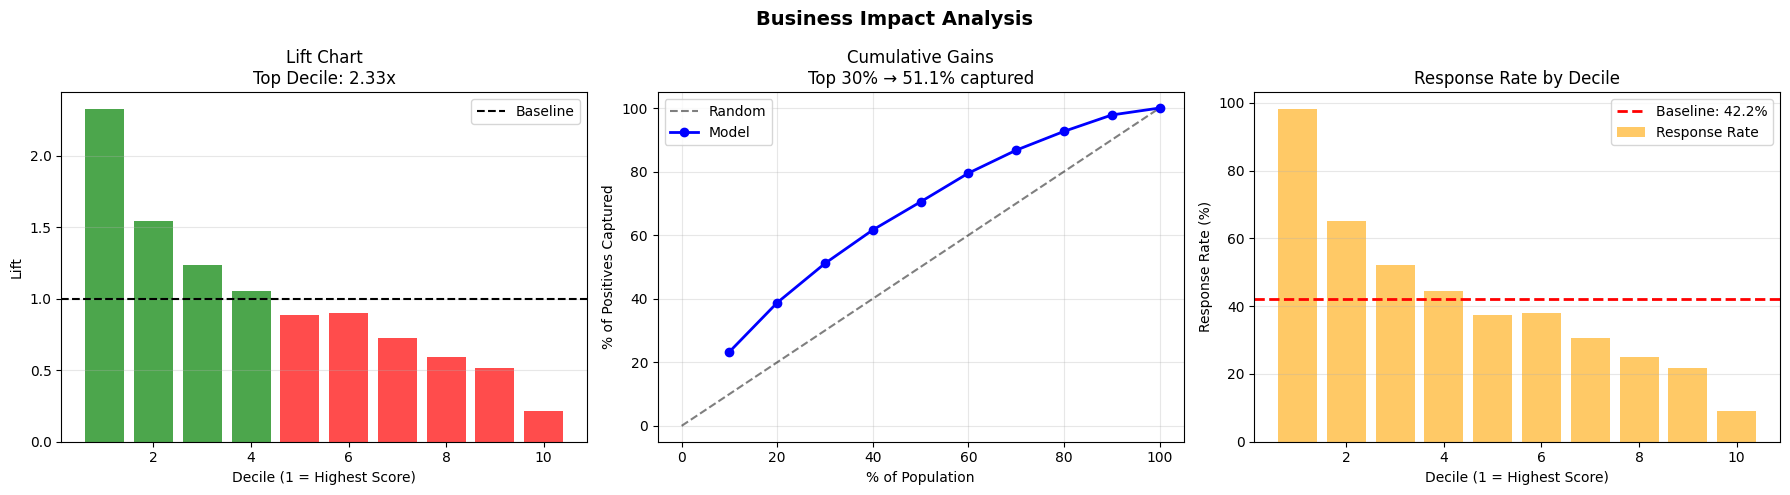

• Top Decile Lift: 0.22x
• Top 30% captures: 51.1% of positives
• Baseline response rate: 42.2%
• Top decile response: 98.2%

📈 STEP 4: CONFUSION MATRIX
----------------------------------------


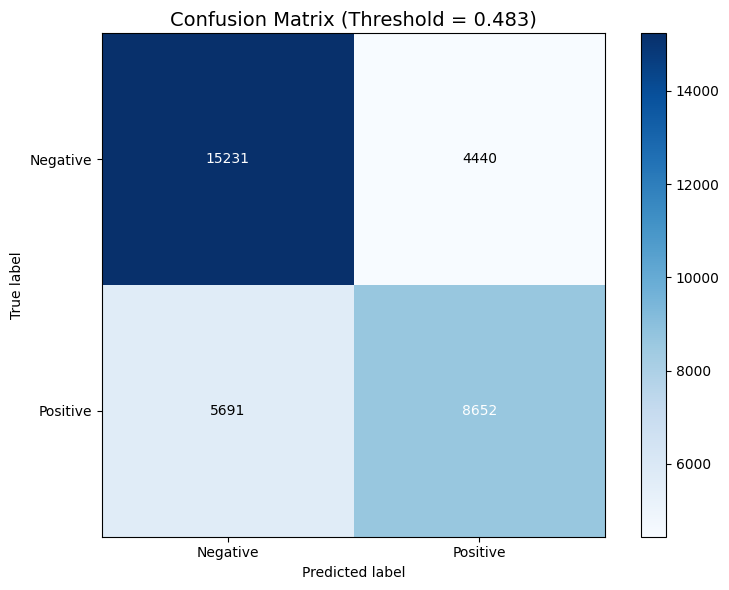

At threshold 0.483:
• Accuracy: 0.702
• Precision: 0.661
• Recall: 0.603
• F1-Score: 0.631
• True Positives: 8652
• False Positives: 4440
• True Negatives: 15231
• False Negatives: 5691

FINAL VALIDATION SUMMARY

✅ DISCRIMINATION POWER:
   KS Statistic: 0.378 (MODERATE discrimination)

✅ BUSINESS VALUE:
   Efficiency: 0.22x better than random
   Coverage: Top 30% → 51.1% captured

✅ MODEL QUALITY:
   ROC-AUC: 0.7680 (Excellent if >0.8)
   PR-AUC: 0.7533 (Excellent if >0.7)

✅ OPERATIONAL METRICS:
   Optimal Threshold: 0.483
   Precision at threshold: 0.661
   Recall at threshold: 0.603


{'y_true': array([0., 0., 1., ..., 0., 0., 0.], shape=(34014,)),
 'y_pred_proba': array([0.40213525, 0.44082413, 0.34709908, ..., 0.44398117, 0.37620996,
        0.44052224], shape=(34014,)),
 'y_pred': array([0, 0, 0, ..., 0, 0, 0], shape=(34014,)),
 'roc_auc': 0.7680170074303199,
 'pr_auc': 0.7533314199825231,
 'ks_statistic': np.float64(0.37750810495908055),
 'optimal_threshold': np.float64(0.48315732813640083),
 'top_decile_lift': np.float64(0.21818643043863245),
 'decile_stats':    decile  count  positives  mean_prob  response_rate      lift  \
 0       1   3402     3342.0   0.877599       0.982363  2.329646   
 1       2   3401     2217.0   0.620798       0.651867  1.545884   
 2       3   3401     1773.0   0.515530       0.521317  1.236288   
 3       4   3402     1510.0   0.489442       0.443857  1.052593   
 4       5   3401     1268.0   0.471889       0.372832  0.884159   
 5       6   3401     1295.0   0.449421       0.380770  0.902986   
 6       7   3402     1037.0   0.420

In [12]:
sequence_df = pd.merge(
    sequence_df, 
    customer_df, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in sequence_df.columns if '_dup' in x]
sequence_df = sequence_df.drop(columns=columns_to_drop, errors='ignore')


new_df = pd.merge(
    new_df,
    sequence_df, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')



print("Columns:", sequence_df.columns.tolist())

# Now it's clear which column is which
y_new = new_df['converted']  # From sequence features
y_sequence = sequence_df['converted']  # From sequence features
y_customer = customer_df['converted']  # From customer features

# For modeling, use the sequence version
X_customer = customer_df.drop(columns=['numero_compte', 'converted'], errors='ignore')
X_customer_clean, y_customer_clean = prepare_features(X_customer, y_customer, "Customer Features")


X_sequence = sequence_df.drop(columns=['numero_compte', 'converted'], errors='ignore')
X_sequence_clean, y_sequence_clean = prepare_features(X_sequence, y_sequence, "Sequence Features")


X_new = new_df.drop(columns=['numero_compte', 'converted'], errors='ignore')
X_new_clean, y_new_clean = prepare_features(X_new, y_new, "New Features")





print("\n" + "="*80)
print("TESTING FEATURE IMPROVEMENT")
print("="*80)

# Test 1: Customer features only (baseline)
print("\n🧪 TEST 1: ENHANCED CUSTOMER FEATURES (Baseline)")
result = train_rf(X_customer_clean, y_customer_clean, 'improved_customer_model')
df = X_customer_clean.copy()
df['converted'] = y_customer_clean
model_evaluation_report(df, result['model'], result['features'], 'converted')

# Test 2: Sequence features (if available)
print("\n🧪 TEST 2: SEQUENCE FEATURES (Advanced)")
result = train_rf(X_sequence_clean, y_sequence_clean, 'sequence_prediction_model')
df = X_sequence_clean.copy()
df['converted'] = y_sequence_clean
model_evaluation_report(df, result['model'], result['features'], 'converted')


# Test 3: New features 
print("\n🧪 TEST 3: NEW FEATURES (Advanced)")
result = train_rf(X_new_clean, y_new_clean, 'sequence_prediction_model')
df = X_new_clean.copy()
df['converted'] = y_new_clean
model_evaluation_report(df, result['model'], result['features'], 'converted')

In [13]:
X_sequence_clean.columns

Index(['avg_days_since_first_quote', 'std_days_since_first_quote',
       'max_days_since_first_quote', 'avg_recent_quote_count',
       'std_recent_quote_count', 'avg_recent_avg_price',
       'std_recent_avg_price', 'avg_recent_price_std', 'std_recent_price_std',
       'avg_recent_product_variety', 'std_recent_product_variety',
       'avg_recent_conversion_rate', 'std_recent_conversion_rate',
       'avg_current_price', 'std_current_price', 'sequence_quote_ratio',
       'price_trend', 'conversion_rate_trend', 'total_quotes',
       'avg_days_between_quotes', 'std_days_between_quotes',
       'max_days_between_quotes', 'engagement_density', 'price_trajectory',
       'unique_product_families', 'product_consistency', 'avg_price',
       'price_range', 'price_volatility', 'main_agency', 'main_region',
       'avg_discount_pct'],
      dtype='object')

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

def diagnose_removed_customers(prev_file, new_file):
    """
    Comprehensive diagnosis of what changed between dataset versions
    """
    print("=" * 100)
    print("COMPREHENSIVE CUSTOMER REMOVAL ANALYSIS")
    print("=" * 100)
    
    # Load both datasets
    df_prev = pd.read_csv(prev_file)
    df_new = pd.read_csv(new_file)
    
    # Ensure we have the key columns
    df_prev['dt_creation_devis'] = pd.to_datetime(df_prev['dt_creation_devis'])
    df_new['dt_creation_devis'] = pd.to_datetime(df_new['dt_creation_devis'])
    
    print(f"Previous dataset: {len(df_prev):,} quotes from {df_prev['numero_compte'].nunique():,} customers")
    print(f"New dataset: {len(df_new):,} quotes from {df_new['numero_compte'].nunique():,} customers")
    print(f"Customers removed: {df_prev['numero_compte'].nunique() - df_new['numero_compte'].nunique():,}")
    print(f"Quotes removed: {len(df_prev) - len(df_new):,}")
    
    # Identify removed and added customers
    prev_customers = set(df_prev['numero_compte'].unique())
    new_customers = set(df_new['numero_compte'].unique())
    
    removed_customers = prev_customers - new_customers
    added_customers = new_customers - prev_customers
    
    print(f"\n1. CUSTOMER CHANGES:")
    print(f"   Removed customers: {len(removed_customers):,}")
    print(f"   Added customers: {len(added_customers):,}")
    print(f"   Common customers: {len(prev_customers & new_customers):,}")
    
    # Get data for removed customers
    df_removed = df_prev[df_prev['numero_compte'].isin(removed_customers)].copy()
    df_kept = df_prev[df_prev['numero_compte'].isin(prev_customers & new_customers)].copy()
    df_added = df_new[df_new['numero_compte'].isin(added_customers)].copy()
    
    # ANALYSIS 1: BASIC CHARACTERISTICS
    print(f"\n{'='*50}")
    print("ANALYSIS 1: BASIC CUSTOMER CHARACTERISTICS")
    print('='*50)
    
    def analyze_customer_group(df, group_name):
        """Analyze a group of customers"""
        if len(df) == 0:
            print(f"\n{group_name}: No data")
            return {}
        
        # Customer-level stats
        customer_stats = df.groupby('numero_compte').agg({
            'numero_compte': 'count',
            'fg_devis_accepte': 'max',
            'mt_apres_remise_ht_devis': 'mean',
            'dt_creation_devis': ['min', 'max']
        }).reset_index()
        
        customer_stats.columns = ['numero_compte', 'total_quotes', 'converted', 
                                  'avg_price', 'first_quote_date', 'last_quote_date']
        
        # Calculate tenure
        customer_stats['tenure_days'] = (customer_stats['last_quote_date'] - 
                                        customer_stats['first_quote_date']).dt.days
        
        stats = {
            'count': len(customer_stats),
            'avg_quotes': customer_stats['total_quotes'].mean(),
            'conversion_rate': customer_stats['converted'].mean(),
            'avg_price': customer_stats['avg_price'].mean(),
            'avg_tenure': customer_stats['tenure_days'].mean(),
            'single_quote_pct': (customer_stats['total_quotes'] == 1).mean() * 100
        }
        
        print(f"\n{group_name}:")
        print(f"  • Customers: {stats['count']:,}")
        print(f"  • Avg quotes per customer: {stats['avg_quotes']:.2f}")
        print(f"  • Conversion rate: {stats['conversion_rate']:.2%}")
        print(f"  • Avg quote price: €{stats['avg_price']:,.0f}")
        print(f"  • Avg tenure (days): {stats['avg_tenure']:.0f}")
        print(f"  • Single-quote customers: {stats['single_quote_pct']:.1f}%")
        
        return stats
    
    # Analyze all groups
    removed_stats = analyze_customer_group(df_removed, "REMOVED CUSTOMERS")
    kept_stats = analyze_customer_group(df_kept, "RETAINED CUSTOMERS")
    added_stats = analyze_customer_group(df_added, "NEWLY ADDED CUSTOMERS")
    
    # ANALYSIS 2: TEMPORAL PATTERNS
    print(f"\n{'='*50}")
    print("ANALYSIS 2: TEMPORAL PATTERNS")
    print('='*50)
    
    def analyze_temporal_patterns(df, group_name):
        """Analyze when these customers were active"""
        if len(df) == 0:
            return
        
        df['quote_year_month'] = df['dt_creation_devis'].dt.to_period('M')
        monthly_counts = df.groupby('quote_year_month').agg({
            'numero_compte': 'nunique',
            'fg_devis_accepte': 'mean'
        }).reset_index()
        
        monthly_counts.columns = ['period', 'unique_customers', 'conversion_rate']
        
        print(f"\n{group_name} - Temporal patterns:")
        print(f"  • First quote date: {df['dt_creation_devis'].min().date()}")
        print(f"  • Last quote date: {df['dt_creation_devis'].max().date()}")
        print(f"  • Peak month: {monthly_counts.loc[monthly_counts['unique_customers'].idxmax(), 'period']}")
        
        # Recent vs historical
        cutoff_date = pd.Timestamp('2024-06-01')  # Adjust based on your data
        recent_mask = df['dt_creation_devis'] >= cutoff_date
        
        if recent_mask.any():
            recent_pct = recent_mask.mean() * 100
            print(f"  • Quotes in last 6 months: {recent_pct:.1f}%")
    
    analyze_temporal_patterns(df_removed, "Removed customers")
    analyze_temporal_patterns(df_kept, "Retained customers")
    analyze_temporal_patterns(df_added, "Added customers")
    
    # ANALYSIS 3: PRODUCT & COMMERCIAL PATTERNS
    print(f"\n{'='*50}")
    print("ANALYSIS 3: PRODUCT & COMMERCIAL CHARACTERISTICS")
    print('='*50)
    
    def analyze_product_commercial(df, group_name):
        """Analyze what products and commercial patterns"""
        if len(df) == 0:
            return
        
        print(f"\n{group_name}:")
        
        # Product family (use new column if available, otherwise old)
        product_col = 'regroup_famille_equipement_produit' if 'regroup_famille_equipement_produit' in df.columns else 'famille_equipement_produit'
        if product_col in df.columns:
            top_products = df[product_col].value_counts().head(3)
            print(f"  Top 3 equipment types:")
            for product, count in top_products.items():
                pct = count / len(df) * 100
                print(f"    • {product}: {pct:.1f}%")
        
        # Brands if available
        if 'marque_produit' in df.columns:
            top_brands = df['marque_produit'].value_counts().head(3)
            print(f"  Top 3 brands:")
            for brand, count in top_brands.items():
                pct = count / len(df) * 100
                print(f"    • {brand}: {pct:.1f}%")
        
        # Commercial function if available
        if 'fonction_commercial' in df.columns:
            top_funcs = df['fonction_commercial'].value_counts().head(3)
            print(f"  Top 3 commercial functions:")
            for func, count in top_funcs.items():
                pct = count / len(df) * 100
                print(f"    • {func}: {pct:.1f}%")
    
    analyze_product_commercial(df_removed, "Removed customers")
    analyze_product_commercial(df_kept, "Retained customers")
    analyze_product_commercial(df_added, "Added customers")
    
    # ANALYSIS 4: CONVERSION PATTERNS
    print(f"\n{'='*50}")
    print("ANALYSIS 4: CONVERSION BEHAVIOR ANALYSIS")
    print('='*50)
    
    def analyze_conversion_patterns(df, group_name):
        """Analyze how conversion happens in this group"""
        if len(df) == 0:
            return
        
        # Conversion by quote position
        df = df.sort_values(['numero_compte', 'dt_creation_devis']).copy()
        df['quote_rank'] = df.groupby('numero_compte').cumcount() + 1
        
        # What quote position converts?
        conversion_by_position = df.groupby('quote_rank')['fg_devis_accepte'].agg(['mean', 'count']).reset_index()
        conversion_by_position.columns = ['quote_position', 'conversion_rate', 'count']
        
        first_quote_conversion = conversion_by_position[conversion_by_position['quote_position'] == 1]['conversion_rate'].values
        if len(first_quote_conversion) > 0:
            print(f"\n{group_name}:")
            print(f"  • First quote conversion rate: {first_quote_conversion[0]:.2%}")
        
        # Time to conversion for converters
        converters = df[df['fg_devis_accepte'] == 1]
        if len(converters) > 0:
            # Get first conversion date for each customer
            first_conversion = converters.groupby('numero_compte')['dt_creation_devis'].min().reset_index()
            first_conversion.columns = ['numero_compte', 'first_conversion_date']
            
            # Merge with first quote date
            first_quote = df.groupby('numero_compte')['dt_creation_devis'].min().reset_index()
            first_quote.columns = ['numero_compte', 'first_quote_date']
            
            conversion_timing = pd.merge(first_conversion, first_quote, on='numero_compte')
            conversion_timing['days_to_convert'] = (conversion_timing['first_conversion_date'] - 
                                                   conversion_timing['first_quote_date']).dt.days
            
            if len(conversion_timing) > 0:
                print(f"  • Avg days to convert: {conversion_timing['days_to_convert'].mean():.0f} days")
    
    analyze_conversion_patterns(df_removed, "Removed customers")
    analyze_conversion_patterns(df_kept, "Retained customers")
    analyze_conversion_patterns(df_added, "Added customers")
    
    # ANALYSIS 5: NEW FEATURES ANALYSIS (Critical for new dataset)
    print(f"\n{'='*50}")
    print("ANALYSIS 5: NEW DATASET FEATURES COMPARISON")
    print('='*50)
    
    # Check which new features are available
    new_features = ['statut_client', 'marque_produit', 'regroup_famille_equipement_produit',
                    'fonction_commercial', 'fg_nouveau_process_relance_devis', 'dt_prem_devis']
    
    available_features = [f for f in new_features if f in df_new.columns]
    print(f"New features available in v3: {available_features}")
    
    # Compare feature distributions between removed and kept customers
    if 'statut_client' in df_removed.columns:
        print(f"\nCLIENT STATUS DISTRIBUTION:")
        
        for group_name, group_df in [("Removed", df_removed), ("Retained", df_kept), ("Added", df_added)]:
            if len(group_df) > 0 and 'statut_client' in group_df.columns:
                status_dist = group_df['statut_client'].value_counts(normalize=True)
                print(f"\n{group_name} customers:")
                for status, pct in status_dist.items():
                    print(f"  • {status}: {pct:.1%}")
    
    if 'fg_nouveau_process_relance_devis' in df_removed.columns:
        print(f"\nNEW PROCESS ADOPTION:")
        
        for group_name, group_df in [("Removed", df_removed), ("Retained", df_kept), ("Added", df_added)]:
            if len(group_df) > 0 and 'fg_nouveau_process_relance_devis' in group_df.columns:
                process_usage = group_df['fg_nouveau_process_relance_devis'].mean()
                print(f"  {group_name}: {process_usage:.1%} use new process")
    
    # ANALYSIS 6: PREDICTIVE POWER ANALYSIS
    print(f"\n{'='*50}")
    print("ANALYSIS 6: PREDICTIVE POWER OF REMOVED VS RETAINED")
    print('='*50)
    
    # Create simple features to see predictive patterns
    def create_diagnostic_features(df):
        """Create features to understand predictive patterns"""
        if len(df) == 0:
            return pd.DataFrame()
        
        features = []
        
        for customer_id, customer_data in df.groupby('numero_compte'):
            f = {'customer_id': customer_id}
            
            # Basic features
            f['total_quotes'] = len(customer_data)
            f['converted'] = customer_data['fg_devis_accepte'].max()
            f['avg_price'] = customer_data['mt_apres_remise_ht_devis'].mean()
            
            # Temporal
            if len(customer_data) > 1:
                time_span = (customer_data['dt_creation_devis'].max() - 
                            customer_data['dt_creation_devis'].min()).days + 1
                f['engagement_density'] = len(customer_data) / time_span
            else:
                f['engagement_density'] = 1
            
            # Product variety
            product_col = 'regroup_famille_equipement_produit' if 'regroup_famille_equipement_produit' in customer_data.columns else 'famille_equipement_produit'
            if product_col in customer_data.columns:
                f['product_variety'] = customer_data[product_col].nunique()
            
            features.append(f)
        
        return pd.DataFrame(features)
    
    # Create features for each group
    removed_features = create_diagnostic_features(df_removed)
    kept_features = create_diagnostic_features(df_kept)
    
    if len(removed_features) > 0 and len(kept_features) > 0:
        print("\nFEATURE COMPARISON (Mean values):")
        print("\nFeature                | Removed | Retained | Difference")
        print("-" * 55)
        
        for feature in ['total_quotes', 'converted', 'avg_price', 'engagement_density']:
            if feature in removed_features.columns and feature in kept_features.columns:
                removed_mean = removed_features[feature].mean()
                kept_mean = kept_features[feature].mean()
                diff = removed_mean - kept_mean
                print(f"{feature:20} | {removed_mean:7.2f} | {kept_mean:8.2f} | {diff:+.3f}")
    
    # ANALYSIS 7: BUSINESS IMPACT ANALYSIS
    print(f"\n{'='*50}")
    print("ANALYSIS 7: BUSINESS IMPACT OF CUSTOMER REMOVAL")
    print('='*50)
    
    # Estimate business impact
    if len(df_removed) > 0:
        # Potential lost revenue
        avg_quote_value = df_removed['mt_apres_remise_ht_devis'].mean()
        conversion_rate = df_removed['fg_devis_accepte'].mean()
        potential_customers = len(removed_customers)
        
        print(f"\nPOTENTIAL BUSINESS IMPACT:")
        print(f"• Customers removed: {potential_customers:,}")
        print(f"• Avg quote value: €{avg_quote_value:,.0f}")
        print(f"• Conversion rate: {conversion_rate:.1%}")
        print(f"• Estimated lost revenue opportunity: €{potential_customers * avg_quote_value * conversion_rate:,.0f}")
        
        # Compare with retained
        avg_quote_kept = df_kept['mt_apres_remise_ht_devis'].mean()
        conversion_kept = df_kept['fg_devis_accepte'].mean()
        
        print(f"\nCOMPARISON WITH RETAINED CUSTOMERS:")
        print(f"• Quote value difference: €{avg_quote_value - avg_quote_kept:+,.0f}")
        print(f"• Conversion rate difference: {conversion_rate - conversion_kept:+.1%}")
    
    # ANALYSIS 8: RECOMMENDATIONS
    print(f"\n{'='*50}")
    print("ANALYSIS 8: DIAGNOSTIC RECOMMENDATIONS")
    print('='*50)
    
    # Generate recommendations based on findings
    recommendations = []
    
    # Check if removed customers were systematically different
    if len(df_removed) > 0 and len(df_kept) > 0:
        # Check conversion rate difference
        conv_diff = df_removed['fg_devis_accepte'].mean() - df_kept['fg_devis_accepte'].mean()
        
        if conv_diff < -0.05:  # Removed customers had much lower conversion
            recommendations.append("REMOVED CUSTOMERS WERE LOW-CONVERTERS: This is GOOD data cleanup")
            recommendations.append("→ Your model should perform BETTER on cleaner data")
            recommendations.append("→ Need to adjust expectations: Original model was trained on noisy data")
        
        elif conv_diff > 0.05:  # Removed customers had higher conversion
            recommendations.append("⚠️ WARNING: REMOVED CUSTOMERS WERE HIGH-CONVERTERS")
            recommendations.append("→ This explains the accuracy drop")
            recommendations.append("→ Need to investigate WHY high-converters were removed")
        
        else:
            recommendations.append("Removed and retained customers have similar conversion rates")
            recommendations.append("→ The accuracy drop may be due to OTHER factors")
    
    # Check temporal patterns
    if len(df_removed) > 0:
        removed_end_date = df_removed['dt_creation_devis'].max()
        kept_end_date = df_kept['dt_creation_devis'].max()
        
        if (kept_end_date - removed_end_date).days > 180:
            recommendations.append("Removed customers were from older time periods")
            recommendations.append("→ This is likely intentional data archiving")
            recommendations.append("→ Consider adding time-based features to handle recency effects")
    
    # Check for systematic patterns in removed customers
    if 'statut_client' in df_removed.columns:
        status_dist_removed = df_removed['statut_client'].value_counts(normalize=True)
        status_dist_kept = df_kept['statut_client'].value_counts(normalize=True)
        
        # Check if specific status was disproportionately removed
        for status in status_dist_removed.index:
            removed_pct = status_dist_removed[status]
            kept_pct = status_dist_kept.get(status, 0)
            
            if abs(removed_pct - kept_pct) > 0.1:  # 10% difference
                recommendations.append(f"⚠️ {status} customers disproportionately affected")
                recommendations.append(f"→ Removed: {removed_pct:.1%}, Kept: {kept_pct:.1%}")
    
    # Print recommendations
    if recommendations:
        print("\nRECOMMENDATIONS BASED ON ANALYSIS:")
        for i, rec in enumerate(recommendations, 1):
            print(f"{i}. {rec}")
    else:
        print("\nNo clear patterns detected in removed customers.")
    
    # Save detailed analysis to file
    print(f"\n{'='*50}")
    print("SAVING DETAILED ANALYSIS")
    print('='*50)
    
    # Create comparison DataFrame
    comparison_data = []
    
    for group_name, group_df in [("Removed", df_removed), ("Retained", df_kept), ("Added", df_added)]:
        if len(group_df) > 0:
            comparison_data.append({
                'Group': group_name,
                'Customers': group_df['numero_compte'].nunique(),
                'Quotes': len(group_df),
                'Avg Quotes per Customer': len(group_df) / group_df['numero_compte'].nunique() if group_df['numero_compte'].nunique() > 0 else 0,
                'Conversion Rate': group_df['fg_devis_accepte'].mean(),
                'Avg Quote Value': group_df['mt_apres_remise_ht_devis'].mean(),
                'First Quote Date': group_df['dt_creation_devis'].min().date(),
                'Last Quote Date': group_df['dt_creation_devis'].max().date()
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Save to CSV
    comparison_df.to_csv('data/customer_removal_analysis.csv', index=False)
    print(f"✓ Detailed analysis saved to: data/customer_removal_analysis.csv")
    
    # Return the data for further analysis
    return {
        'df_removed': df_removed,
        'df_kept': df_kept,
        'df_added': df_added,
        'removed_customers': removed_customers,
        'kept_customers': prev_customers & new_customers,
        'added_customers': added_customers,
        'comparison_df': comparison_df
    }

# Run the analysis
if __name__ == "__main__":
    prev_file = "data/data_hes_quotes_france_202512-2.csv"
    new_file = "data/data_hes_quotes_france_202512-3.csv"
    
    print("Starting comprehensive customer removal analysis...")
    results = diagnose_removed_customers(prev_file, new_file)
    
    # Additional targeted analysis based on initial findings
    print(f"\n{'='*100}")
    print("ADDITIONAL TARGETED ANALYSIS")
    print('='*100)
    
    if results['df_removed'] is not None and len(results['df_removed']) > 0:
        # Check specific hypotheses
        
        # Hypothesis 1: Were removed customers mostly single-quote?
        removed_customer_quotes = results['df_removed'].groupby('numero_compte').size()
        single_quote_removed = (removed_customer_quotes == 1).mean() * 100
        
        kept_customer_quotes = results['df_kept'].groupby('numero_compte').size()
        single_quote_kept = (kept_customer_quotes == 1).mean() * 100
        
        print(f"\nSINGLE-QUOTE CUSTOMER ANALYSIS:")
        print(f"• Removed customers: {single_quote_removed:.1f}% had only one quote")
        print(f"• Retained customers: {single_quote_kept:.1f}% had only one quote")
        
        if single_quote_removed > single_quote_kept + 10:
            print("→ REMOVAL BIAS: Single-quote customers disproportionately removed")
        
        # Hypothesis 2: Were removed customers from specific agencies/regions?
        if 'nom_agence' in results['df_removed'].columns:
            top_agencies_removed = results['df_removed']['nom_agence'].value_counts(normalize=True).head(3)
            top_agencies_kept = results['df_kept']['nom_agence'].value_counts(normalize=True).head(3)
            
            print(f"\nTOP AGENCIES ANALYSIS:")
            print("Removed customers - Top 3 agencies:")
            for agency, pct in top_agencies_removed.items():
                print(f"  • {agency}: {pct:.1%}")
            
            print("\nRetained customers - Top 3 agencies:")
            for agency, pct in top_agencies_kept.items():
                print(f"  • {agency}: {pct:.1%}")
        
        # Hypothesis 3: Time-based removal?
        print(f"\nTIME-BASED ANALYSIS:")
        print(f"Removed customers - Quote date range:")
        print(f"  • Earliest: {results['df_removed']['dt_creation_devis'].min().date()}")
        print(f"  • Latest: {results['df_removed']['dt_creation_devis'].max().date()}")
        
        print(f"\nRetained customers - Quote date range:")
        print(f"  • Earliest: {results['df_kept']['dt_creation_devis'].min().date()}")
        print(f"  • Latest: {results['df_kept']['dt_creation_devis'].max().date()}")
        
        # Check if removed customers are from older time periods
        removed_latest = results['df_removed']['dt_creation_devis'].max()
        kept_latest = results['df_kept']['dt_creation_devis'].max()
        
        if (kept_latest - removed_latest).days > 90:
            print(f"\n→ TIME BIAS: Removed customers are from older time periods")
            print(f"  Latest removed quote: {removed_latest.date()}")
            print(f"  Latest kept quote: {kept_latest.date()}")
            print(f"  Difference: {(kept_latest - removed_latest).days} days")

Starting comprehensive customer removal analysis...
COMPREHENSIVE CUSTOMER REMOVAL ANALYSIS
Previous dataset: 38,697 quotes from 25,940 customers
New dataset: 34,275 quotes from 23,898 customers
Customers removed: 2,042
Quotes removed: 4,422

1. CUSTOMER CHANGES:
   Removed customers: 3,031
   Added customers: 989
   Common customers: 22,909

ANALYSIS 1: BASIC CUSTOMER CHARACTERISTICS

REMOVED CUSTOMERS:
  • Customers: 3,031
  • Avg quotes per customer: 1.18
  • Conversion rate: 45.20%
  • Avg quote price: €3,607
  • Avg tenure (days): 14
  • Single-quote customers: 85.7%

RETAINED CUSTOMERS:
  • Customers: 22,909
  • Avg quotes per customer: 1.53
  • Conversion rate: 40.63%
  • Avg quote price: €7,070
  • Avg tenure (days): 23
  • Single-quote customers: 65.5%

NEWLY ADDED CUSTOMERS:
  • Customers: 989
  • Avg quotes per customer: 1.30
  • Conversion rate: 21.33%
  • Avg quote price: €6,567
  • Avg tenure (days): 0
  • Single-quote customers: 75.5%

ANALYSIS 2: TEMPORAL PATTERNS

Remo

In [15]:
import time


In [16]:
def benchmark_function(func, *args, **kwargs):
    start = time.time()
    result = func(*args, **kwargs)
    end = time.time()
    return result, end - start

# Test both versions
original_time = benchmark_function(create_timeline_features, df_quotes)[1]
print(original_time)

CREATING SAFE TIMELINE FEATURES (NO LEAKAGE)
Using safe date column: 'dt_creation_devis'
Processing 23,888 customers

✅ Created 7 SAFE timeline features
   REMOVED: company_tenure_days, first_quote_recency (potential leakage)
0.1460113525390625


In [17]:
import pandas as pd
import numpy as np


def create_timeline_features_safe(
    df: pd.DataFrame,
    customer_col: str = "numero_compte",
    safe_date_col: str = "dt_creation_devis",  # Primary safe date
    first_quote_col: str = None,  # Optional: dt_prem_devis (use with caution!)
) -> pd.DataFrame:
    """
    LEAKAGE-SAFE timeline features using only safe date columns
    """
    print("=" * 80)
    print("CREATING SAFE TIMELINE FEATURES (NO LEAKAGE)")
    print("=" * 80)
    
    # Check essential column
    if safe_date_col not in df.columns:
        print(f"⚠️ WARNING: '{safe_date_col}' column not found")
        return pd.DataFrame(columns=[customer_col])
    
    print(f"Using safe date column: '{safe_date_col}'")
    print(f"Processing {df[customer_col].nunique():,} customers")
    
    # Make working copy with ONLY safe columns
    df_work = df[[customer_col, safe_date_col]].copy()
    
    # Add first quote date if explicitly requested AND safe
    if first_quote_col and first_quote_col in df.columns:
        print(f"⚠️ Using '{first_quote_col}' - verify this is known at quote time")
        df_work[first_quote_col] = df[first_quote_col]
    
    # Convert dates
    df_work[safe_date_col] = pd.to_datetime(df_work[safe_date_col], errors='coerce')
    if first_quote_col and first_quote_col in df_work.columns:
        df_work[first_quote_col] = pd.to_datetime(df_work[first_quote_col], errors='coerce')
    
    # Remove invalid dates
    valid_mask = df_work[safe_date_col].notna()
    df_work = df_work[valid_mask].copy()
    
    if len(df_work) == 0:
        print("⚠️ No valid date data available")
        return pd.DataFrame(columns=[customer_col])
    
    # Sort chronologically
    df_work = df_work.sort_values([customer_col, safe_date_col]).reset_index(drop=True)
    
    # ========== SAFE FEATURES ONLY ==========
    
    # Basic sequence
    df_work['quote_seq'] = df_work.groupby(customer_col).cumcount()
    df_work['total_quotes'] = df_work.groupby(customer_col)[safe_date_col].transform('count')
    
    # Safe tenure (only based on quotes in dataset)
    first_dates = df_work.groupby(customer_col)[safe_date_col].transform('first')
    last_dates = df_work.groupby(customer_col)[safe_date_col].transform('last')
    df_work['customer_tenure_days'] = (last_dates - first_dates).dt.days + 1
    df_work['customer_tenure_days'] = df_work['customer_tenure_days'].clip(lower=1)
    
    # Safe frequency
    df_work['quote_frequency'] = df_work['total_quotes'] / df_work['customer_tenure_days']
    
    # Time between quotes (safe)
    df_work['prev_date'] = df_work.groupby(customer_col)[safe_date_col].shift()
    df_work['days_since_prev'] = (df_work[safe_date_col] - df_work['prev_date']).dt.days
    
    # Aggregate to customer level
    result = pd.DataFrame({
        'total_quotes': df_work.groupby(customer_col).size(),
        'customer_tenure_days': df_work.groupby(customer_col)['customer_tenure_days'].first(),
        'quote_frequency': df_work.groupby(customer_col)['quote_frequency'].first(),
    })
    
    # Time stats
    time_stats = df_work.groupby(customer_col)['days_since_prev'].agg(
        avg_days_between_quotes='mean',
        time_between_quotes_std='std',
        max_days_between_quotes='max',
        min_days_between_quotes='min'
    ).fillna(0)
    
    result = result.join(time_stats)
    
    # Engagement consistency
    result['engagement_consistency'] = 1 - np.minimum(
        result['time_between_quotes_std'] / result['avg_days_between_quotes'].replace(0, 1), 
        1
    )
    
    # Seasonality (safe - only uses month)
    df_work['month'] = df_work[safe_date_col].dt.month
    month_counts = df_work.groupby([customer_col, 'month']).size().unstack(fill_value=0)
    
    result['peak_engagement_month'] = month_counts.idxmax(axis=1)
    result['month_concentration'] = month_counts.max(axis=1) / month_counts.sum(axis=1)
    
    # Winter/summer ratios
    winter_mask = df_work['month'].isin([11, 12, 1, 2, 3])
    summer_mask = df_work['month'].isin([6, 7, 8, 9])
    
    winter_counts = df_work[winter_mask].groupby(customer_col).size()
    summer_counts = df_work[summer_mask].groupby(customer_col).size()
    
    result['winter_quote_ratio'] = winter_counts / result['total_quotes']
    result['summer_quote_ratio'] = summer_counts / result['total_quotes']
    result['seasonal_concentration'] = result[['winter_quote_ratio', 'summer_quote_ratio']].max(axis=1).fillna(0)
    
    # ========== REMOVED DANGEROUS FEATURES ==========
    # ❌ company_tenure_days (uses dt_prem_devis)
    # ❌ first_quote_recency (uses dt_prem_devis)  
    # ❌ days_to_first_conversion (uses conversion dates)
    # ❌ Any features using dt_prem_contrat, dt_facture_*
    
    print(f"\n✅ Created {len(result.columns)} SAFE timeline features")
    print("   REMOVED: company_tenure_days, first_quote_recency (potential leakage)")
    
    return result.reset_index()
    
optimized_time = benchmark_function(create_timeline_features_safe, df_quotes)[1]
speedup = original_time / optimized_time
print(f"Speedup: {speedup:.1f}x")

CREATING SAFE TIMELINE FEATURES (NO LEAKAGE)
Using safe date column: 'dt_creation_devis'
Processing 23,888 customers

✅ Created 13 SAFE timeline features
   REMOVED: company_tenure_days, first_quote_recency (potential leakage)
Speedup: 0.7x


In [18]:
def complete_feature_safety_assessment(df_quotes):
    """
    Complete safety assessment for all process features
    Returns detailed report with specific issues found
    """
    print("=" * 80)
    print("COMPLETE FEATURE SAFETY ASSESSMENT")
    print("=" * 80)
    
    results = {}
    issues = []
    
    # Define all expected features
    all_features = [
        # Group 1: Current features
        ('current_process_new', 'CURRENT'),
        ('current_process_missing', 'CURRENT'),
        
        # Group 2: Historical counts
        ('hist_total_quotes', 'HIST_COUNT'),
        ('historical_quotes_with_process', 'HIST_COUNT'),
        ('historical_process_switches', 'HIST_COUNT'),
        
        # Group 3: Historical patterns
        ('historical_process_adoption_rate', 'HIST_PATTERN'),
        ('historical_process_consistency', 'HIST_PATTERN'),
        ('is_first_quote', 'HIST_PATTERN'),
        ('process_consistency_with_history', 'HIST_PATTERN'),
        ('process_deviation_from_history', 'HIST_PATTERN'),
        ('process_trend', 'HIST_PATTERN'),
        
        # Group 4: Success rates (HIGH RISK)
        ('hist_success_new_process', 'SUCCESS_RATE'),
        ('hist_success_old_process', 'SUCCESS_RATE'),
    ]
    
    # Check each feature
    for feature_name, feature_type in all_features:
        if feature_name not in df_quotes.columns:
            results[feature_name] = '❌ NOT FOUND'
            continue
            
        # Run type-specific checks
        if feature_type == 'CURRENT':
            results[feature_name] = '✅ SAFE'
            
        elif feature_type == 'HIST_COUNT':
            # Check basic properties
            if df_quotes[feature_name].min() < 0:
                issues.append(f"{feature_name}: Negative values found")
                results[feature_name] = '⚠️ CHECK'
            else:
                results[feature_name] = '✅ LIKELY SAFE'
                
        elif feature_type == 'HIST_PATTERN':
            # Check first quotes
            if 'quote_index' in df_quotes.columns:
                first_quotes = df_quotes[df_quotes['quote_index'] == 0]
                if len(first_quotes) > 0:
                    # Features should be 0 or default for first quotes
                    if feature_name in ['historical_process_adoption_rate', 
                                       'process_deviation_from_history']:
                        non_zero = first_quotes[first_quotes[feature_name] != 0]
                        if len(non_zero) > 0:
                            issues.append(f"{feature_name}: Non-zero for first quotes")
                            results[feature_name] = '⚠️ CHECK'
                        else:
                            results[feature_name] = '✅ SAFE (with timeline check)'
                    elif feature_name == 'is_first_quote':
                        # Should be 1 for quote_index == 0
                        mismatch = first_quotes[first_quotes[feature_name] != 1]
                        if len(mismatch) > 0:
                            issues.append(f"{feature_name}: Not 1 for first quotes")
                            results[feature_name] = '⚠️ CHECK'
                        else:
                            results[feature_name] = '✅ SAFE'
                    else:
                        results[feature_name] = '✅ SAFE (with timeline check)'
                else:
                    results[feature_name] = '✅ SAFE (with timeline check)'
            else:
                results[feature_name] = '✅ NEEDS QUOTE_INDEX TO VERIFY'
                
        elif feature_type == 'SUCCESS_RATE':
            # HIGH RISK FEATURES
            if 'quote_index' in df_quotes.columns:
                first_quotes = df_quotes[df_quotes['quote_index'] == 0]
                if len(first_quotes) > 0:
                    # Success rates should be 0 for first quotes
                    if feature_name in ['hist_success_new_process', 
                                       'hist_success_old_process',
                                       'process_effectiveness_gap']:
                        non_zero = first_quotes[first_quotes[feature_name] != 0]
                        if len(non_zero) > 0:
                            issues.append(f"{feature_name}: Non-zero for first quotes - IMPOSSIBLE")
                            results[feature_name] = '🔴 LEAKAGE DETECTED'
                        else:
                            results[feature_name] = '🔴 HIGH RISK (business timeline needed)'
                    else:
                        results[feature_name] = '🔴 HIGH RISK (business timeline needed)'
                else:
                    results[feature_name] = '🔴 HIGH RISK (business timeline needed)'
            else:
                results[feature_name] = '🔴 HIGH RISK (needs quote_index to check)'
    
    # Print results in a nice table
    print("\nFEATURE SAFETY ASSESSMENT:")
    print("=" * 80)
    
    # Group by safety level
    safety_levels = {
        '✅ SAFE': [],
        '✅ LIKELY SAFE': [],
        '✅ SAFE (with timeline check)': [],
        '✅ NEEDS QUOTE_INDEX TO VERIFY': [],
        '⚠️ CHECK': [],
        '🔴 HIGH RISK (business timeline needed)': [],
        '🔴 LEAKAGE DETECTED': [],
        '🔴 HIGH RISK (needs quote_index to check)': [],
        '❌ NOT FOUND': []
    }
    
    for feature, assessment in results.items():
        if assessment in safety_levels:
            safety_levels[assessment].append(feature)
    
    # Print by safety level
    for level, features in safety_levels.items():
        if features:
            print(f"\n{level}:")
            print("-" * 60)
            for feature in sorted(features):
                print(f"  • {feature}")
    
    # Print issues found
    if issues:
        print(f"\n{"=" * 80}")
        print("ISSUES FOUND:")
        print("=" * 80)
        for issue in issues:
            print(f"⚠️  {issue}")
    else:
        print(f"\n{"=" * 80}")
        print("✅ NO CRITICAL ISSUES FOUND")
        print("=" * 80)
    
    # Summary and recommendations
    print(f"\n{"=" * 80}")
    print("RECOMMENDATIONS:")
    print("=" * 80)
    
    high_risk_count = len(safety_levels.get('🔴 HIGH RISK (business timeline needed)', [])) + \
                     len(safety_levels.get('🔴 LEAKAGE DETECTED', [])) + \
                     len(safety_levels.get('🔴 HIGH RISK (needs quote_index to check)', []))
    
    if high_risk_count > 0:
        print(f"""
🚨 {high_risk_count} HIGH-RISK FEATURES DETECTED

IMMEDIATE ACTIONS REQUIRED:
1. Remove all 🔴 HIGH RISK features from production
2. Answer this BUSINESS QUESTION:
   "When predicting Quote #N, do we know if Quote #N-1 converted yet?"
   
BUSINESS TIMELINE SCENARIOS:
• INSTANT decisions (same day) → Success rate features MIGHT be safe
• DAYS/WEEKS to decide → Success rate features DEFINITELY leak
• Multiple pending quotes → Success rate features DEFINITELY leak

SAFE PATH FORWARD:
Use only ✅ SAFE and ✅ LIKELY SAFE features:
• Current process info (1-2)
• Historical counts (3-5)  
• Historical patterns (6-9)
""")
    else:
        print("""
✅ ALL FEATURES LOOK SAFE

NEXT STEPS:
1. Verify business timeline anyway (how quickly do customers decide?)
2. Monitor model performance for unexpected improvements
3. Consider A/B testing with/without historical patterns
""")
    
    return results, issues

# Run the assessment
safety_results, issues_found = complete_feature_safety_assessment(X_new_clean)

COMPLETE FEATURE SAFETY ASSESSMENT

FEATURE SAFETY ASSESSMENT:

✅ SAFE:
------------------------------------------------------------
  • current_process_missing
  • current_process_new

✅ LIKELY SAFE:
------------------------------------------------------------
  • hist_total_quotes
  • historical_quotes_with_process

✅ NEEDS QUOTE_INDEX TO VERIFY:
------------------------------------------------------------
  • historical_process_adoption_rate
  • historical_process_consistency
  • is_first_quote
  • process_consistency_with_history
  • process_deviation_from_history

🔴 HIGH RISK (needs quote_index to check):
------------------------------------------------------------
  • hist_success_new_process
  • hist_success_old_process

❌ NOT FOUND:
------------------------------------------------------------
  • historical_process_switches
  • process_trend

✅ NO CRITICAL ISSUES FOUND

RECOMMENDATIONS:

🚨 2 HIGH-RISK FEATURES DETECTED

IMMEDIATE ACTIONS REQUIRED:
1. Remove all 🔴 HIGH RISK feat

In [19]:
def validate_feature_consistency(df_raw, X_engineered):
    """
    Verify that engineered features in X_engineered match
    what we create from df_raw (sanity check)
    """
    print("=" * 80)
    print("VALIDATING FEATURE CONSISTENCY")
    print("=" * 80)
    
    # Re-create features from raw data
    print("1. Creating features from raw data...")
    timeline_from_raw = create_timeline_features(df_raw)
    commercial_from_raw = create_commercial_role_features(df_raw)
    process_from_raw = create_process_features(df_raw)
    
    # Check which features exist in both
    print("\n2. Comparing with engineered dataset...")
    
    # Timeline features comparison
    timeline_cols = set(timeline_from_raw.columns) & set(X_engineered.columns)
    print(f"   Timeline features in both: {len(timeline_cols)}")
    
    # Commercial features comparison  
    commercial_cols = set(commercial_from_raw.columns) & set(X_engineered.columns)
    print(f"   Commercial features in both: {len(commercial_cols)}")
    
    # Process features comparison
    process_cols = set(process_from_raw.columns) & set(X_engineered.columns)
    print(f"   Process features in both: {len(process_cols)}")
    
    # Sample comparison for key features
    print("\n3. Sample value comparison:")
    if 'customer_tenure_days' in timeline_cols:
        raw_mean = timeline_from_raw['customer_tenure_days'].mean()
        eng_mean = X_engineered['customer_tenure_days'].mean()
        print(f"   customer_tenure_days - Raw: {raw_mean:.2f}, Engineered: {eng_mean:.2f}")
    
    if 'has_senior_commercial' in commercial_cols:
        raw_mean = commercial_from_raw['has_senior_commercial'].mean()
        eng_mean = X_engineered['has_senior_commercial'].mean()
        print(f"   has_senior_commercial - Raw: {raw_mean:.2f}, Engineered: {eng_mean:.2f}")
    
    return True

# Run validation
validate_feature_consistency(df_quotes, X_new_clean)

VALIDATING FEATURE CONSISTENCY
1. Creating features from raw data...
CREATING SAFE TIMELINE FEATURES (NO LEAKAGE)
Using safe date column: 'dt_creation_devis'
Processing 23,888 customers

✅ Created 7 SAFE timeline features
   REMOVED: company_tenure_days, first_quote_recency (potential leakage)
✅ Created 3 LEAKAGE-SAFE commercial features
   REMOVED: total_quotes, unique_roles, senior_commercial_count (potential leakage)
Created 11 process features
→ 34,014 quotes | 23,888 customers

2. Comparing with engineered dataset...
   Timeline features in both: 7
   Commercial features in both: 3
   Process features in both: 11

3. Sample value comparison:
   has_senior_commercial - Raw: 0.02, Engineered: 0.02


True

In [20]:
def check_dangerous_features_in_X(X_engineered):
    """
    Check if X_new_clean contains dangerous timeline features
    """
    print("=" * 80)
    print("CHECKING X_new_clean FOR DANGEROUS TIMELINE FEATURES")
    print("=" * 80)
    
    dangerous_patterns = [
        'company_tenure',  # Uses dt_prem_devis
        'first_quote_recency',  # Uses dt_prem_devis
        'contrat',  # Contract dates
        'facture',  # Invoice dates
        'conversion',  # Conversion timing
        'days_to_first'  # Time to outcome
    ]
    
    found_dangerous = []
    found_safe = []
    
    for col in X_engineered.columns:
        col_lower = str(col).lower()
        
        if any(pattern in col_lower for pattern in dangerous_patterns):
            found_dangerous.append(col)
        elif any(pattern in col_lower for pattern in ['tenure', 'frequency', 'season', 'month', 'quarter']):
            found_safe.append(col)
    
    print(f"Found {len(found_dangerous)} potentially dangerous features:")
    for col in found_dangerous[:20]:  # Show first 20
        print(f"  🔴 {col}")
    
    if len(found_dangerous) > 20:
        print(f"  ... and {len(found_dangerous) - 20} more")
    
    print(f"\nFound {len(found_safe)} likely safe timeline features:")
    for col in found_safe[:10]:
        print(f"  🟢 {col}")
    
    if len(found_dangerous) > 0:
        print(f"\n🚨 RECOMMENDATION: Remove {len(found_dangerous)} dangerous features")
        print("   These likely cause data leakage")
    
    return found_dangerous, found_safe

# Run the check
if 'X_new_clean' in locals():
    dangerous, safe = check_dangerous_features_in_X(X_new_clean)

CHECKING X_new_clean FOR DANGEROUS TIMELINE FEATURES
Found 5 potentially dangerous features:
  🔴 brand_conversion_alignment
  🔴 brand_conversion_consistency
  🔴 avg_recent_conversion_rate
  🔴 std_recent_conversion_rate
  🔴 conversion_rate_trend

Found 7 likely safe timeline features:
  🟢 primary_season_focus
  🟢 seasonal_concentration
  🟢 seasonal_equipment_mix
  🟢 has_multi_season
  🟢 peak_engagement_month
  🟢 month_concentration
  🟢 mature_seasonal_focus

🚨 RECOMMENDATION: Remove 5 dangerous features
   These likely cause data leakage


In [21]:
# Safe column discovery
print("=" * 80)
print("df_quotes COLUMNS DISCOVERY (SAFE VERSION)")
print("=" * 80)
print(f"Total columns: {len(df_quotes.columns)}")
print(f"Total rows: {len(df_quotes):,}")

# Show first 20 columns
print("\nFIRST 20 COLUMNS IN df_quotes:")
for i, col in enumerate(list(df_quotes.columns)[:20], 1):
    try:
        dtype = str(df_quotes[col].dtype)
        non_null = df_quotes[col].notna().sum()
        unique = df_quotes[col].nunique()
        print(f"{i:2}. {col:35} {dtype:15} non-null: {non_null:6,} unique: {unique:6}")
    except:
        print(f"{i:2}. {col:35} ERROR getting dtype")

# Show all columns in a compact format
print("\nALL COLUMNS (compact):")
cols_per_line = 5
all_columns = list(df_quotes.columns)
for i in range(0, len(all_columns), cols_per_line):
    print("  " + ", ".join(all_columns[i:i+cols_per_line]))

df_quotes COLUMNS DISCOVERY (SAFE VERSION)
Total columns: 47
Total rows: 34,014

FIRST 20 COLUMNS IN df_quotes:
 1. id_devis                            object          non-null: 34,014 unique:  34014
 2. num_devis                           object          non-null: 34,014 unique:  34014
 3. nom_devis                           object          non-null: 34,014 unique:  32702
 4. nom_agence                          object          non-null: 34,014 unique:     21
 5. nom_filiale_zone                    object          non-null: 34,014 unique:     14
 6. nom_region                          object          non-null: 34,014 unique:      5
 7. statut_devis                        object          non-null: 34,014 unique:      9
 8. fg_devis_emis                       float64         non-null: 34,014 unique:      2
 9. fg_devis_refuse                     float64         non-null: 34,014 unique:      2
10. fg_devis_accepte                    float64         non-null: 34,014 unique:      2
11. dt_c

In [22]:
# Quick check before running full function
def check_chronological_integrity(df, customer_col="numero_compte", date_col="dt_creation_devis"):
    """Quick check for chronological issues"""
    df_check = df[[customer_col, date_col]].copy()
    df_check[date_col] = pd.to_datetime(df_check[date_col], errors='coerce')
    
    issues = []
    for customer in df_check[customer_col].unique()[:100]:  # Check first 100 customers
        cust_dates = df_check[df_check[customer_col] == customer][date_col].dropna()
        if not cust_dates.is_monotonic_increasing:
            issues.append(customer)
    
    if issues:
        print(f"❌ Found {len(issues)} customers with non-chronological quotes")
        print(f"   Example customers: {issues[:5]}")
        return False
    else:
        print("✅ All checked customers have chronological quotes")
        return True

# Run check
check_chronological_integrity(df_quotes)

❌ Found 36 customers with non-chronological quotes
   Example customers: ['CL00271344', 'CL00290622', 'CL00305103', 'CL00337825', 'CL00333975']


False

In [23]:
# Add this validation function to your pipeline
def validate_no_temporal_leakage(df, customer_col, date_col):
    """Ensure no data leakage from non-chronological data"""
    df_temp = df.sort_values([customer_col, date_col])
    
    # Create a sequence ID to check ordering
    df_temp['seq_id'] = df_temp.groupby(customer_col).cumcount()
    df_temp['orig_index'] = df_temp.index
    
    # Check if original order matches chronological order
    df_check = df_temp.groupby(customer_col).apply(
        lambda x: not x.index.equals(x.sort_values(date_col).index)
    )
    
    problematic_customers = df_check[df_check].index.tolist()
    
    if problematic_customers:
        print(f"🚨 DATA LEAKAGE RISK: {len(problematic_customers)} customers need re-sorting")
        return False, problematic_customers
    return True, []

# Use it
is_safe, problem_customers = validate_no_temporal_leakage(
    df_quotes, "numero_compte", "dt_creation_devis"
)

🚨 DATA LEAKAGE RISK: 2 customers need re-sorting
